<a href="https://colab.research.google.com/github/lg960214/DACON_Seoul_6/blob/develop/Geo_PipeLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [273]:
!pip install geopandas #geopandas
!pip install xlrd==1.2.0 #xls 읽기 위해
!pip install rtree pygeos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [274]:
#필수 패키지 임포트
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import os

In [334]:
def read_df(y, m, sheet=2): #sheet 2는 월별 무임유임 승하차 데이터, sheet3은 일별시간별 승하차데이터
  rootdir = '/content/drive/MyDrive/DACON6/지하철 이용 정보/교통카드 통계자료' #승하차 데이터 루트 경로

  sub_dirs = {} #sub_dirs[year][month]로 해당 월의 xls 파일경로를 가져올 수 있도록 딕셔너리 만듦.
  for year in os.listdir(rootdir):
    sub_sub_dirs = {}
    for month in os.listdir(os.path.join(rootdir, year)):
      sub_sub_dirs[int(month.split(' ')[1][:2])] = os.path.join(rootdir, year, month)
    sub_dirs[int(year)] = sub_sub_dirs

  df = pd.read_excel(sub_dirs[y][m], sheet_name=sheet, thousands=',')

  if sheet==2:
    df = df.drop(columns=['호선명', '역ID', '작업일시', '사용월'])
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  if sheet==3:
    df = df.iloc[1:, 3:-1]
    c = ['지하철역']
    for i in range(24):
      c.append(f'{(i+3)%24}시승차')
      c.append(f'{(i+3)%24}시하차')
    df.columns = c
    temp = df['지하철역']
    df = df[df.columns[1:]].astype('int')
    df['지하철역'] = temp
    df = df.groupby(by='지하철역').sum()
    df['지하철역'] = df.index
    df.index = list(range(len(df)))
  return df

In [315]:
def to_geodf(df, epsg=5179):
  dir_station = '/content/drive/MyDrive/DACON6/지하철 시설 정보/서울시 역사마스터 정보.csv' #역 좌표 데이터
  df_station = pd.read_csv(dir_station, encoding='cp949')
  df_station = df_station.drop(columns=['역사_ID', '호선'])
  df_station = df_station.groupby(by='역사명').mean()
  df_station['지하철역'] = df_station.index
  df_station.index = list(range(len(df_station))) #읽어와서 필요없는 컬럼 지우고 중복되는 역은 좌표를 평균냄

  df = pd.merge(df, df_station, on='지하철역') #역 좌표 데이터를 승하차 데이터와 통합

  s = gpd.GeoSeries([Point(x, y) for x, y in zip(df['위도'], df['경도'])]) #위도 경도 데이터를 GeoSeries Point 로 변환
  
  geodf = gpd.GeoDataFrame(df, geometry=s) # GeoDataFrame 생성
  geodf.crs = 'epsg:4326' #현재 좌표계는 위도경도(epsg4326)
  geodf = geodf.to_crs(epsg=epsg) #경계 데이터 좌표계는(epsg5179) 이걸로 변환
  geodf = geodf.drop(columns=['위도', '경도']) #기존 위도 경도는 제거
  
  return geodf

In [316]:
def to_density(geodf, geojson=False): #True 일 경우 geojson 파일로 리턴
  geo = None
  geodf = geodf.drop(columns=['지하철역'])

  dir_shp = '/content/drive/MyDrive/DACON6/서울시 지리 정보/통계지역경계/행정구역.shp' #.shp 파일 경로(서울시 행정구역 단위 경계 데이터)
  seoul = gpd.read_file(dir_shp) #경계 데이터 읽기
  seoul.crs = 'epsg:5179' # 좌표계

  temp = []
  #geodf을 통해 경계 구역 내 지하철 역의 데이터를 모두 더해 밀도로 변환
  station_pos = geodf.geometry
  for i, g in enumerate(seoul.geometry):
    idx = station_pos.within(g)
    temp.append(geodf[idx].iloc[:, :-1].sum().to_numpy().T)

  temp = np.stack(temp)
  c = geodf.columns[:-1]
  for i, col in enumerate(c):
    seoul[col] = temp[:, i]

  if geojson:
    geo = seoul.to_json()
  else:
    geo = seoul

  return geo

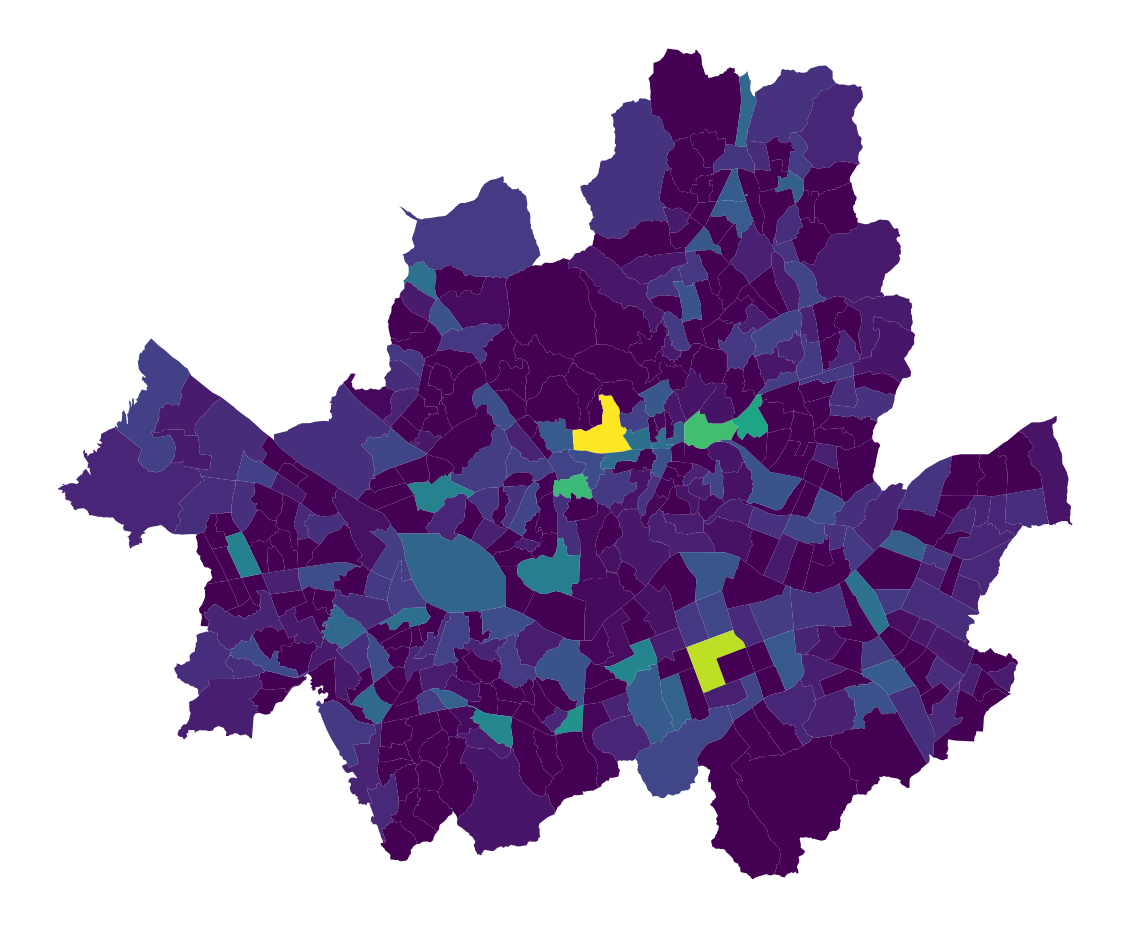

In [328]:
#단순 무유임 승하차 밀도 시각화
df = read_df(2022, 9, 2)
subway = to_geodf(df)
seoul = to_density(subway, False) #True로 바꾸면 geoJson

plt.rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots()
ax.axis('off')
seoul.plot('무임승차', ax=ax)

plt.show()

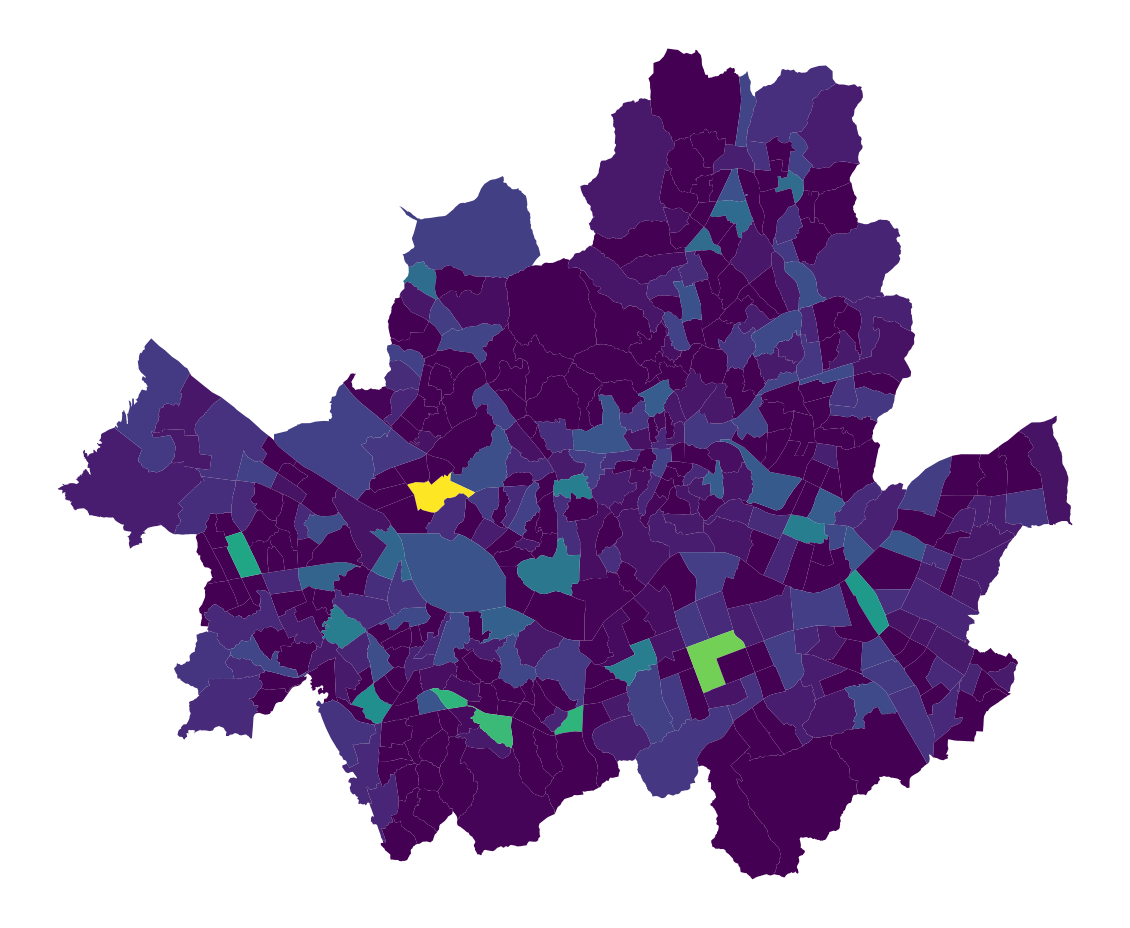

In [345]:
#시간대별 전체 승하차
df = read_df(2022, 9, 3)

time_dict = {'아침승차':['7시승차', '8시승차'], '아침하차':['7시하차', '8시하차'], '점심승차':['14시승차','15시승차'], '점심하차':['14시하차','15시하차'], '저녁승차':['18시승차', '19시승차'], '저녁하차':['18시하차', '19시하차']}
for s in ['아침승차', '아침하차', '점심승차', '점심하차', '저녁승차', '저녁하차']:
  df[s] = df[time_dict[s]].mean(axis=1)

geodf = to_geodf(df)
seoul = to_density(geodf)

plt.rcParams['figure.figsize'] = (20, 20)
fig, ax = plt.subplots()
ax.axis('off')
seoul.plot('저녁하차', ax=ax)

plt.show()